In [622]:
from ProSpect_Classifier.finetune_v1 import l2_contrastive_loss,load_model_from_config,load_img,eval_error
from omegaconf import OmegaConf
import torch
from dataloaders.dataloaders import SetDataManager
from dataloaders.dataloaders_for_classifier import Dataloader_classifier
from ProSpect_Classifier.scheduler import Scheduler 

In [623]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


config="../configs/stable-diffusion/v1-inference.yaml"
ckpt="../models/sd/sd-v1-4.ckpt"
config = OmegaConf.load(f"{config}")
model = load_model_from_config(config, f"{ckpt}")
model = model.to(device)

Loading model from ../models/sd/sd-v1-4.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
make_beta_schedule:linear
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.21.mlp.fc2.weight', 'vision_model.encoder.layers.3.self_attn.q_proj.weight', 'vision_model.encoder.layers.5.layer_norm1.weight', 'vision_model.encoder.layers.15.self_attn.q_proj.weight', 'vision_model.encoder.layers.19.self_attn.q_proj.weight', 'vision_model.encoder.layers.10.self_attn.out_proj.weight', 'vision_model.encoder.layers.3.self_attn.k_proj.bias', 'vision_model.encoder.layers.5.self_attn.k_proj.bias', 'vision_model.encoder.layers.11.self_attn.v_proj.bias', 'vision_model.encoder.layers.14.self_attn.q_proj.weight', 'vision_model.encoder.layers.2.mlp.fc2.weight', 'vision_model.encoder.layers.12.layer_norm1.weight', 'vision_model.encoder.layers.12.self_attn.q_proj.weight', 'vision_model.encoder.layers.23.mlp.fc1.bias', 'vision_model.encoder.layers.23.layer_norm2.weight', 'vision_model.encoder.layers.4.self_attn.q_proj.weight', 'vision_

In [651]:
"""Loading the dataloader parameter """

inference_file = "./data/CUB'/test/novel.json"
dataloader_params = dict(
		image_size=224,		
		num_aug=100,
		n_way=5,
		n_support=0,
		n_episode=300,
		n_query=5)
    
novel_loader = SetDataManager(**dataloader_params).get_data_loader(inference_file)

In [652]:
class_embeddings1 = torch.load("./logs/class_embeddings.pth")

class_embeddings2 = torch.load("./logs/class_embeddings_l2_21.pth")

class_embeddings3 = torch.load("./class_embeddings_actual.pth")

In [653]:
condition1 = [class_embeddings1[i] for i in range(7)]   # l2 + Contrastive
condition1 = torch.cat(condition1,dim=0)

condition2 = [class_embeddings2[i] for i in range(7)]       ## l2
condition2 = torch.cat(condition2,dim=0)

condition3 = [class_embeddings3[i] for i in range(7)]       ## l2
condition3 = torch.cat(condition3,dim=0)

In [654]:
x,x_ft,y = next(iter(novel_loader))

In [655]:
y

tensor([[6., 6., 6., 6., 6.],
        [3., 3., 3., 3., 3.],
        [5., 5., 5., 5., 5.],
        [0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.]])

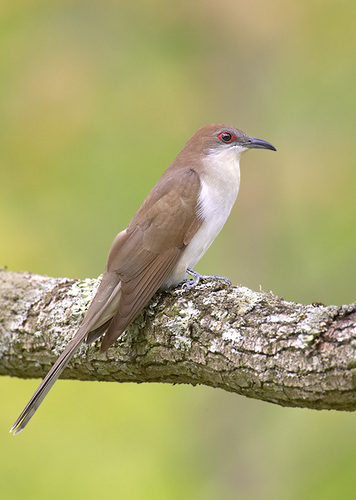

In [682]:
x1=x_ft[4][4]
x1

In [657]:
y1=y[1][2]
y1

tensor(3.)

In [672]:
def error_calcn(model,latent,batch_size,dtype,loss,condition,label_idx,latent_size=64):
    
    
    T = 1000
    # max_n_samples = max(args.n_samples) ##50
    max_n_samples = 10
    torch.manual_seed(7)
    all_noise = torch.randn((max_n_samples , 4, latent_size, latent_size), device=latent.device) * 0.25
    scheduler = Scheduler()
    
    start = T // max_n_samples // 2
    # import pdb; pdb.set_trace() #Ankit
    ts = list(range(start, T, T // max_n_samples))[:max_n_samples]
    noise_idxs = range(0,max_n_samples)
    text_embed_idxs = [label_idx for _ in range(max_n_samples)]
    
    # import pdb; pdb.set_trace() #Ankit
    pred_errors = eval_error(model, scheduler , latent, all_noise, ts, noise_idxs,
                                 condition, text_embed_idxs ,batch_size ,dtype ,loss)
    
    
    return pred_errors

In [683]:
res_1 = []
res_2 = []
res_3 = []

content_image = load_img(x1).to(device)


batch_size =5
dtype = "float32"
loss = "l2"
latent = model.get_first_stage_encoding(model.encode_first_stage(content_image))

for i in range(5):
    
    loss1=error_calcn(model,latent,batch_size,dtype,loss,condition1,int(y[i][0].item())) ## With the L2  + Contrastive
    loss2=error_calcn(model,latent,batch_size,dtype,loss,condition2,int(y[i][0].item())) ## with the L2
    loss3=error_calcn(model,latent,batch_size,dtype,loss,condition3,int(y[i][0].item()))
    torch.cuda.empty_cache()
    res_1.append(loss1)     ## with the L2+Contrastive
    res_2.append(loss2)     ## with the L2 only
    res_3.append(loss3)

In [662]:
def __sum_tensor_(x):
    return [i.sum() for i in x]

In [684]:
__sum_tensor_(res_1) 

[tensor(1.1279),
 tensor(1.1329),
 tensor(1.1495),
 tensor(1.1343),
 tensor(1.1088)]

In [685]:
__sum_tensor_(res_2) 

[tensor(1.1289),
 tensor(1.1323),
 tensor(1.1426),
 tensor(1.1285),
 tensor(1.1183)]

In [686]:
__sum_tensor_(res_3) 

[tensor(1.1258),
 tensor(1.1386),
 tensor(1.1390),
 tensor(1.1242),
 tensor(1.1163)]

: 

In [574]:
[i - j for i,j in zip(res_1,res_2)]

[tensor(-0.1512),
 tensor(-0.1442),
 tensor(-0.1407),
 tensor(-0.0175),
 tensor(0.0024),
 tensor(-0.0053)]